# Research Question 1: River extent of influence

What is the spatial extent of influence of the river contribution to surface waters in the CAA?
- Does the RCD span full straits in the CAA? If so, which and during all seasons or only for a portion of the year?
- How long does it take for river contributions in the central CAA to reach Baffin Bay?

Correlate the time series of discharge and fluxes

In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [43]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from dateutil.relativedelta import relativedelta
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from scipy.signal import find_peaks
import seaborn as sns; sns.set()
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

##### Load domain dimensions for reference:

In [44]:
imin, imax = 1480, 2050
jmin, jmax = 160, 800

In [45]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:])

mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
lons  = np.array(mesh.variables['nav_lon'])
lats  = np.array(mesh.variables['nav_lat'])
tmask = tmask[0,:,imin:imax,jmin:jmax]

In [46]:
ref   = nc.Dataset('/data/brogalla/run_storage/trial4/ref-2003/ANHA12_EXH006_2003_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

##### Load boundary coordinates:

In [47]:
l1i = 2013-imin; l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin; l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin; l6j = np.arange(660-jmin,690-jmin)

t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin

r1i = 1520-imin; r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin; r2j = np.arange(385-jmin,405-jmin)

N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares
P1i = 1585-imin; P1j = np.arange(485-jmin,538-jmin)  #Parry channel

#### Load pickled time series calculations (5d):

In [48]:
def time_series_pickle(year, riv_2a=False, riv_2b=False):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # Load calculated time series of fluxes:
    if riv_2a:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(folder+'time-series-20190930-riv-2a'+str(year)+'.pickle','rb'))  
    elif riv_2b:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(folder+'time-series-riv-2b'+str(year)+'.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
                pickle.load(open(folder+'time-series-20190930-ref'+str(year)+'.pickle','rb'))
    
    # Conservation of volume check:
    sum_V = -1*np.sum(time_series_V1,axis=2) - np.sum(time_series_V2,axis=2) - np.sum(time_series_V7,axis=2) - \
           (np.sum(time_series_V3,axis=2) + np.sum(time_series_V4,axis=2) + np.sum(time_series_V5,axis=2) + \
            np.sum(time_series_V6,axis=2)) + np.sum(time_series_V8,axis=2) + np.sum(time_series_V9,axis=2)
#     print('Total volume change at end of time period: ', np.sum(sum_V))
    
    # Combine western CAA time series:
    time_series_mn_WCAA = np.sum(np.sum(time_series_mn3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn6,axis=2),axis=1)
    time_series_V_WCAA = np.sum(np.sum(time_series_V3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V6,axis=2),axis=1)
    
    return time_series_mn1, time_series_mn2, time_series_mn_WCAA, time_series_mn7, time_series_mn8, \
            time_series_mn9, time_series_mn10, time_series_mn11

In [53]:
ts_2002_mn1, ts_2002_mn2, ts_2002_mn_WCAA, ts_2002_mn7, ts_2002_mn8, ts_2002_mn9, ts_2002_mn10, ts_2002_mn11 = time_series_pickle(2002)
ts_2003_mn1, ts_2003_mn2, ts_2003_mn_WCAA, ts_2003_mn7, ts_2003_mn8, ts_2003_mn9, ts_2003_mn10, ts_2003_mn11 = time_series_pickle(2003)
ts_2004_mn1, ts_2004_mn2, ts_2004_mn_WCAA, ts_2004_mn7, ts_2004_mn8, ts_2004_mn9, ts_2004_mn10, ts_2004_mn11 = time_series_pickle(2004)
ts_2005_mn1, ts_2005_mn2, ts_2005_mn_WCAA, ts_2005_mn7, ts_2005_mn8, ts_2005_mn9, ts_2005_mn10, ts_2005_mn11 = time_series_pickle(2005)
ts_2006_mn1, ts_2006_mn2, ts_2006_mn_WCAA, ts_2006_mn7, ts_2006_mn8, ts_2006_mn9, ts_2006_mn10, ts_2006_mn11 = time_series_pickle(2006)
ts_2007_mn1, ts_2007_mn2, ts_2007_mn_WCAA, ts_2007_mn7, ts_2007_mn8, ts_2007_mn9, ts_2007_mn10, ts_2007_mn11 = time_series_pickle(2007)
ts_2008_mn1, ts_2008_mn2, ts_2008_mn_WCAA, ts_2008_mn7, ts_2008_mn8, ts_2008_mn9, ts_2008_mn10, ts_2008_mn11 = time_series_pickle(2008)
ts_2009_mn1, ts_2009_mn2, ts_2009_mn_WCAA, ts_2009_mn7, ts_2009_mn8, ts_2009_mn9, ts_2009_mn10, ts_2009_mn11 = time_series_pickle(2009)
ts_2010_mn1, ts_2010_mn2, ts_2010_mn_WCAA, ts_2010_mn7, ts_2010_mn8, ts_2010_mn9, ts_2010_mn10, ts_2010_mn11 = time_series_pickle(2010)
ts_2011_mn1, ts_2011_mn2, ts_2011_mn_WCAA, ts_2011_mn7, ts_2011_mn8, ts_2011_mn9, ts_2011_mn10, ts_2011_mn11 = time_series_pickle(2011)
ts_2012_mn1, ts_2012_mn2, ts_2012_mn_WCAA, ts_2012_mn7, ts_2012_mn8, ts_2012_mn9, ts_2012_mn10, ts_2012_mn11 = time_series_pickle(2012)
ts_2013_mn1, ts_2013_mn2, ts_2013_mn_WCAA, ts_2013_mn7, ts_2013_mn8, ts_2013_mn9, ts_2013_mn10, ts_2013_mn11 = time_series_pickle(2013)
ts_2014_mn1, ts_2014_mn2, ts_2014_mn_WCAA, ts_2014_mn7, ts_2014_mn8, ts_2014_mn9, ts_2014_mn10, ts_2014_mn11 = time_series_pickle(2014)
ts_2015_mn1, ts_2015_mn2, ts_2015_mn_WCAA, ts_2015_mn7, ts_2015_mn8, ts_2015_mn9, ts_2015_mn10, ts_2015_mn11 = time_series_pickle(2015)
ts_2016_mn1, ts_2016_mn2, ts_2016_mn_WCAA, ts_2016_mn7, ts_2016_mn8, ts_2016_mn9, ts_2016_mn10, ts_2016_mn11 = time_series_pickle(2016)
ts_2017_mn1, ts_2017_mn2, ts_2017_mn_WCAA, ts_2017_mn7, ts_2017_mn8, ts_2017_mn9, ts_2017_mn10, ts_2017_mn11 = time_series_pickle(2017)
ts_2018_mn1, ts_2018_mn2, ts_2018_mn_WCAA, ts_2018_mn7, ts_2018_mn8, ts_2018_mn9, ts_2018_mn10, ts_2018_mn11 = time_series_pickle(2018)

### Time series across boundaries:

- Positive --- into domain
- Negative --- out of domain

In [50]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir('/data/brogalla/run_storage/ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

In [51]:
dates_2002 = file_dates(2002); dates_2003 = file_dates(2003); dates_2004 = file_dates(2004);
dates_2005 = file_dates(2005); dates_2006 = file_dates(2006); dates_2007 = file_dates(2007);
dates_2008 = file_dates(2008); dates_2009 = file_dates(2009); dates_2010 = file_dates(2010);
dates_2011 = file_dates(2011); dates_2012 = file_dates(2012); dates_2013 = file_dates(2013);
dates_2014 = file_dates(2014); dates_2015 = file_dates(2015); dates_2016 = file_dates(2016);
dates_2017 = file_dates(2017); dates_2018 = file_dates(2018);

In [52]:
dates = np.array(dates_2002+dates_2003+dates_2004+dates_2005+dates_2006+dates_2007+dates_2008+dates_2009+\
                 dates_2010+dates_2011+dates_2012+dates_2013+dates_2014+dates_2015+dates_2016+dates_2017+dates_2018)

Separated by layer: (year, 5day within year)

In [54]:
def flux_layer(top, bottom):
    in_BB  = np.empty((17, 72))
    out_BB = np.empty((17, 72))
    in_N   = np.empty((17, 72))
    out_N  = np.empty((17, 72))

    count = 0
    for year in range(2002, 2019):
        ts_year_mn1, ts_year_mn2, ts_year_mn_WCAA, ts_year_mn7, ts_year_mn8, ts_year_mn9, \
        ts_year_mn10, ts_year_mn11 = time_series_pickle(year)

        for date in range(0,72):
            in_BB[count,date]  = np.sum(ts_year_mn8[date, top:bottom, :][ts_year_mn8[date, top:bottom, :] >= 0])
            out_BB[count,date] = np.sum(ts_year_mn8[date, top:bottom, :][ts_year_mn8[date, top:bottom, :] < 0])
            in_N[count,date]   = np.sum(ts_year_mn10[date, top:bottom, :][ts_year_mn10[date, top:bottom, :] >= 0])
            out_N[count,date]  = np.sum(ts_year_mn10[date, top:bottom, :][ts_year_mn10[date, top:bottom, :] < 0])            

        count+=1
        
    return in_BB, out_BB, in_N, out_N

In [55]:
in_BB_surf, out_BB_surf, in_N_surf, out_N_surf     = flux_layer(0, 18)
in_BB_total, out_BB_total, in_N_total, out_N_total = flux_layer(0, 50)

In [14]:
print(dates.shape, in_BB_surf.flatten().shape)

(1224,) (1224,)


/home/brogalla/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


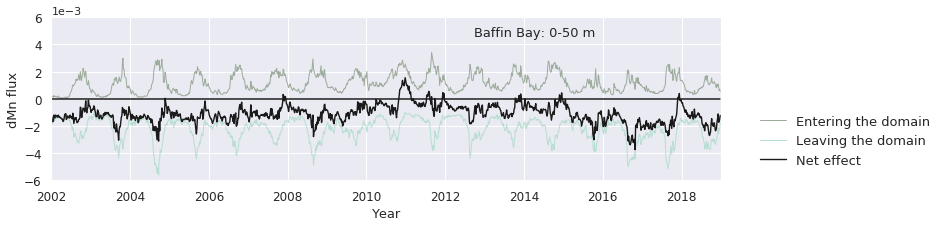

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12,3))

ax.plot(dates, in_BB_surf.flatten(),  c='#9dac9c', linewidth=1.0, label='Entering the domain')
ax.plot(dates, out_BB_surf.flatten(), c='#b8ded3', linewidth=1.0, label='Leaving the domain')
ax.plot(dates, out_BB_surf.flatten()+in_BB_surf.flatten(), c='k', linewidth=1.4, label='Net effect')
ax.plot([dates_2002[0], dates_2018[-1]], [0, 0], '-k')

ax.set_xlim([dt.datetime(2002,1,1), dt.datetime(2019,1,1)])
ax.set_ylim([-6e-3, 6e-3])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('dMn flux', fontsize=13)
ax.text(dates_2012[-20], 4.6e-3, 'Baffin Bay: 0-50 m', fontsize=13)

ax.legend(loc=(1.05, 0.05), frameon=False, fontsize=13)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/BB-time-series-20190925-surface.png', bbox_inches='tight')

Load river discharge information

In [56]:
rf = np.empty((18*12, imax-imin, jmax-jmin))

i=0
for year in range(2002, 2019):
    for month in range(0,12):
        c = nc.Dataset('/data/brogalla/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y'+str(year)+'.nc','r')
        rf[i*12+month,:,:] = np.array(c.variables['runoff'])[month,imin:imax,jmin:jmax]
        
    i+=1

In [57]:
rf_time_series = np.sum(rf, axis=(1,2))

In [58]:
rclass = nc.Dataset('/ocean/brogalla/GEOTRACES/data/rivers/river_class_201807.nc','r')
river_class = rclass.variables['rclass']
river_class = np.array(river_class)

In [59]:
glacial_class = (river_class[1480:2050, 160:800]==1.0)
contine_class = (river_class[1480:2050, 160:800]==2.0)

In [60]:
griv = rf[:,:,:]*glacial_class
criv = rf[:,:,:]*contine_class

In [61]:
gc_time_series = np.sum(griv, axis=(1,2))
cn_time_series = np.sum(criv, axis=(1,2))

In [62]:
months = np.array([dates[2] + relativedelta(months=i) for i in range(0,18*12)])

Identify the temporal lag:

In [63]:
norm_rf = rf_time_series/np.amax(rf_time_series)
norm_gc = gc_time_series/np.amax(gc_time_series)
norm_cn = cn_time_series/np.amax(cn_time_series)
norm_mn = -1*out_BB_surf.flatten()/np.amax(np.abs(out_BB_surf))

In [64]:
rf_i, _ = find_peaks(norm_rf, width=1, height=0.4)
gc_i, _ = find_peaks(norm_gc, width=1.5, height=0.4)
cn_i, _ = find_peaks(norm_cn, width=1, height=0.4)
mn_i, _ = find_peaks(norm_mn, width=7, height=0.5)

In [65]:
diff_rf = dates[mn_i]-months[rf_i]
drf = [i.days for i in diff_rf]

In [66]:
diff_gc = dates[mn_i]-months[gc_i]
dgc = [i.days for i in diff_gc]

In [67]:
diff_cn = dates[mn_i]-months[cn_i]
dcn = [i.days for i in diff_cn]

In [68]:
time_lag = np.abs(drf) # in days
print('Total runoff sum:')
print('Average lag time (days): ', np.average(time_lag))
print('Maximum lag time (days): ', np.amax(time_lag))
print('Minimum lag time (days): ', np.amin(time_lag))
print('Standard deviation of lag time (days): ', np.std(time_lag))

Total runoff sum:
Average lag time (days):  92.23529411764706
Maximum lag time (days):  129
Minimum lag time (days):  64
Standard deviation of lag time (days):  16.972397701474716


In [69]:
time_lag = np.abs(dgc) # in days
print('Glacial runoff sum:')
print('Average lag time (days): ', np.average(time_lag))
print('Maximum lag time (days): ', np.amax(time_lag))
print('Minimum lag time (days): ', np.amin(time_lag))
print('Standard deviation of lag time (days): ', np.std(time_lag))

Glacial runoff sum:
Average lag time (days):  92.23529411764706
Maximum lag time (days):  129
Minimum lag time (days):  64
Standard deviation of lag time (days):  16.972397701474716


In [70]:
time_lag = np.abs(dcn) # in days
print('Continental runoff sum:')
print('Average lag time (days): ', np.average(time_lag))
print('Maximum lag time (days): ', np.amax(time_lag))
print('Minimum lag time (days): ', np.amin(time_lag))
print('Standard deviation of lag time (days): ', np.std(time_lag))

Continental runoff sum:
Average lag time (days):  90.47058823529412
Maximum lag time (days):  129
Minimum lag time (days):  64
Standard deviation of lag time (days):  17.72043568399067


Text(0, 0.5, 'Kernel density estimate')

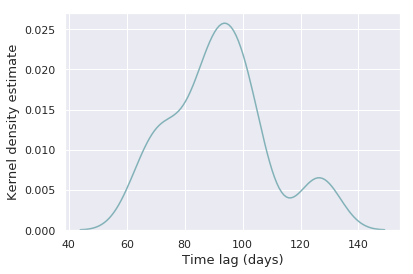

In [42]:
distribution = sns.distplot(time_lag, hist=False, color='#82b2b8')
distribution.set_xlabel('Time lag (days)', fontsize=13)
distribution.set_ylabel('Kernel density estimate', fontsize=13)
# plt.savefig("/ocean/brogalla/GEOTRACES/figures/BB-time-lag-20191003.png")

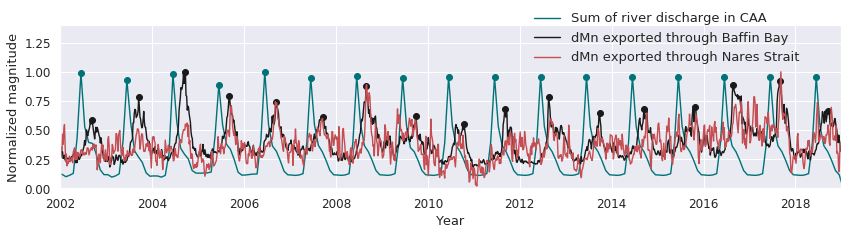

In [32]:
fig, ax = plt.subplots(1,1, figsize=(14,3))

# ax2 = plt.subplot2grid((1, 4), (0, 0), colspan=3)

ax.scatter(dates[mn_i], norm_mn[mn_i], c='k')
ax.scatter(months[rf_i], norm_rf[rf_i], c='#007378')

ax.plot(months, rf_time_series/np.amax(rf_time_series), c='#007378', linewidth=1.4, label='Sum of river discharge in CAA')
ax.plot(dates, -1*out_BB_surf.flatten()/np.amax(np.abs(out_BB_surf)), c='k', linewidth=1.4, \
        label='dMn exported through Baffin Bay')
ax.plot(dates, -1*out_N_surf.flatten()/np.amax(np.abs(out_N_surf)), c='r', linewidth=1.4, \
        label='dMn exported through Nares Strait')

ax.set_xlim([dt.datetime(2002,1,1), dt.datetime(2019,1,1)])
ax.set_ylim([0.0, 1.4])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('Normalized magnitude', fontsize=13)

ax.legend(loc=(0.60, 0.73), frameon=False, fontsize=13)

# distribution = sns.distplot(time_lag, hist=False, color='#82b2b8', ax=ax[3])
# distribution.set_xlabel('Time lag (days)', fontsize=13)
# distribution.set_ylabel('Kernel density estimate', fontsize=13)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/BB-time-series-20191001-surface.png', bbox_inches='tight')

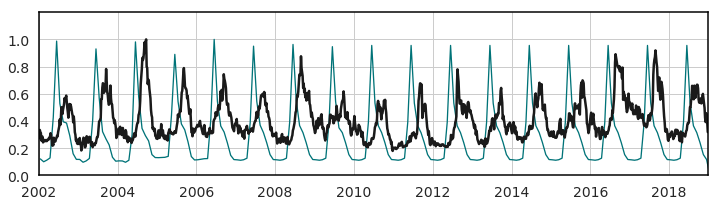

In [33]:
fig = plt.figure(figsize=(12,3))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(months, rf_time_series/np.amax(rf_time_series), linewidth=1.3, color='#007378')
    sns.lineplot(dates, -1*out_BB_surf.flatten()/np.amax(np.abs(out_BB_surf)), linewidth=2.5, color='k')
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set(ylim=(0.0, 1.2), xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

# label='Sum of river discharge in CAA'
# label='dMn exported through Baffin Bay')

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/river-delay.png', bbox_inches='tight', dpi=300)

Nares strait flux:

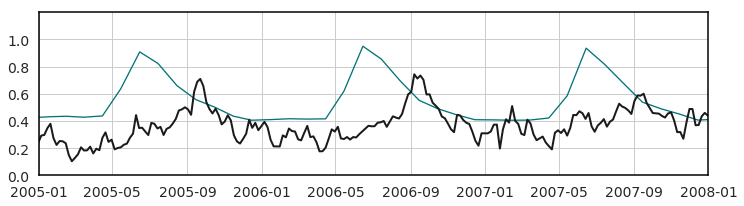

In [39]:
fig = plt.figure(figsize=(12,3))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(months, gc_time_series/np.amax(gc_time_series), linewidth=1.3, color='#007378')
    sns.lineplot(dates, -1*out_N_surf.flatten()/np.amax(np.abs(out_N_surf)), linewidth=2.0, color='k')
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set(ylim=(0.0, 1.2), xlim=(dt.datetime(2005,1,1), dt.datetime(2008,1,1)))
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

# label='Sum of river discharge in CAA'
# label='dMn exported through Baffin Bay')

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/river-delay.png', bbox_inches='tight', dpi=300)

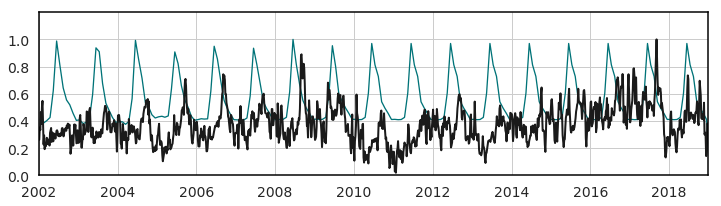

In [38]:
fig = plt.figure(figsize=(12,3))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(months, gc_time_series/np.amax(gc_time_series), linewidth=1.3, color='#007378')
    sns.lineplot(dates, -1*out_N_surf.flatten()/np.amax(np.abs(out_N_surf)), linewidth=2.0, color='k')
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set(ylim=(0.0, 1.2), xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

# label='Sum of river discharge in CAA'
# label='dMn exported through Baffin Bay')

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/river-delay.png', bbox_inches='tight', dpi=300)

Select rivers from within certain regions:

In [ ]:
rf = np.array(rf)
lon_rf = np.array(lon_rf)
lat_rf = np.array(lat_rf)
rf[rf == 0] = np.nan
lon_rf[rf == 0.0] = np.nan
lat_rf[rf == 0.0] = np.nan

proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x_rf, y_rf = proj(lon_rf, lat_rf)
CS = proj.scatter(x_rf[combined_monthly>0], y_rf[combined_monthly>0], \
                  c=combined_monthly[combined_monthly>0], vmax=10, s=60, cmap=cmocean.cm.amp, zorder=3)
CBar = plt.colorbar(CS, shrink=0.6)
CBar.set_label('dMn contribution [nM]', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)